In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,GRU




In [6]:
def cargar_depurar_datos(archivo):
    """
    Carga y depura un archivo CSV de precios de Bitcoin mensual,
    devolviendo tanto el DataFrame limpio como una estructura
    tipo lista de diccionarios de diccionarios.
    """
    
    df = pd.read_csv(archivo, skiprows=2)

    
    df = df.rename(columns={
        "Date": "Date",
        "Unnamed: 1": "Close",
        "Unnamed: 2": "High",
        "Unnamed: 3": "Low",
        "Unnamed: 4": "Open",
        "Unnamed: 5": "Volume"
    })

    
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    
    for col in ["Close", "High", "Low", "Open", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

   
    df.dropna(inplace=True)

   
    df.set_index("Date", inplace=True)

    return df
archivo = "C:/Users/jeron/OneDrive/Escritorio/CoinPredictor/Datos/bitcoin_diario.csv"
df = cargar_depurar_datos(archivo)

print(df.info())



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4048 entries, 2014-09-17 to 2025-10-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4048 non-null   float64
 1   High    4048 non-null   float64
 2   Low     4048 non-null   float64
 3   Open    4048 non-null   float64
 4   Volume  4048 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 189.8 KB
None


In [7]:
set_entrenamiento = df.loc[:"2023-12-31"].iloc[:,1:2]
set_validacion = df.loc["2024-01-01":].iloc[:,1:2]

set_entrenamiento.info()
set_validacion.info()

set_entrenamiento.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3393 entries, 2014-09-17 to 2023-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    3393 non-null   float64
dtypes: float64(1)
memory usage: 53.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 655 entries, 2024-01-01 to 2025-10-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    655 non-null    float64
dtypes: float64(1)
memory usage: 10.2 KB


,High
Date,
2023-12-27,43683.160156
2023-12-28,43804.781250
2023-12-29,43124.324219
2023-12-30,42584.125000
2023-12-31,42860.937500


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))


set_entrenamiento_escalado = scaler.fit_transform(set_entrenamiento)

print(set_entrenamiento_escalado)

[[0.00373944]
 [0.00357446]
 [0.00315122]
 ...
 [0.62574965]
 [0.61787249]
 [0.62190896]]


In [9]:
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)


for i in range(time_step,m):
    # X: bloques
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [12]:
#Construir el modelo

print('Comenzando el entrenamiento...')

modelo = Sequential()

#Capa 1
modelo.add(GRU(units=50, return_sequences = True, input_shape = (X_train.shape[1],1)))
modelo.add(Dropout(0.2))

#Capa 2
modelo.add(GRU(units=50, return_sequences = True))
modelo.add(Dropout(0.2))

#Capa 3
modelo.add(GRU(units=50))
modelo.add(Dropout(0.1))

#Capa 4
modelo.add(Dense(units = 1))



modelo.compile(optimizer='adam', loss='mean_squared_error')

modelo.fit(X_train, Y_train, epochs=25, batch_size=32)
print("Modelo entrenado exitosamente")

Comenzando el entrenamiento...


c:\Users\jeron\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.0062
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0013
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0011
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0011
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0011
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0011
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 9.7264e-04
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 8.4278e-04
Epoch 9/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 7.9273e-04
Epoch 10/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 8.1021e-04
Epoch 11/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 8.2904e-04
Epoch 12/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 7.3978e-04
Epoch 13/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 6.4993e-04
Epoch 14/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 7.6850e-04
Epoch 15/25

In [13]:
#test y predicicones
x_test = set_validacion.values
x_test_scaled = scaler.transform(x_test)

X_test = []
for i in range(time_step,len(x_test_scaled)):
    X_test.append(x_test_scaled[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = scaler.inverse_transform(prediccion)

print(prediccion)


c:\Users\jeron\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
[[ 56319.477]
 [ 56535.11 ]
 [ 56518.06 ]
 [ 57075.156]
 [ 60108.242]
 [ 61465.867]
 [ 61102.03 ]
 [ 61391.074]
 [ 62721.918]
 [ 62465.348]
 [ 63104.066]
 [ 64908.082]
 [ 65462.98 ]
 [ 66087.164]
 [ 66478.23 ]
 [ 65958.39 ]
 [ 64696.965]
 [ 63768.   ]
 [ 63529.492]
 [ 62997.363]
 [ 62754.438]
 [ 62684.727]
 [ 61795.66 ]
 [ 61131.93 ]
 [ 61754.426]
 [ 63727.26 ]
 [ 64454.93 ]
 [ 64748.152]
 [ 64858.242]
 [ 64645.445]
 [ 64352.277]
 [ 64832.01 ]
 [ 64978.332]
 [ 64160.34 ]
 [ 62497.73 ]
 [ 63213.63 ]
 [ 63153.39 ]
 [ 63459.223]
 [ 63907.69 ]
 [ 65277.133]
 [ 65200.766]
 [ 64844.85 ]
 [ 64926.82 ]
 [ 64972.96 ]
 [ 63291.383]
 [ 61683.83 ]
 [ 61742.875]
 [ 60404.324]
 [ 59883.94 ]
 [ 59514.844]
 [ 59973.863]
 [ 60040.39 ]
 [ 60128.1  ]
 [ 60931.758]
 [ 61166.445]
 [ 61159.508]
 [ 60279.227]
 [ 59767.07 ]
 [ 59178.61 ]
 [ 59160.543]
 [ 59052.652]
 [ 59229.95 ]
 [ 57262.6  ]
 [ 55951.535]
 [ 57448.426]
 [ 58483.43 ]
 [ 58730.316]
 [ 59291.184]
 [ 58964

In [14]:


p = np.mean(prediccion)
t = np.mean(x_test)

ac = 0
if p > t:
    ac = round((t/p)*100,2)
else:
    ac = round((p/t)*100,2)

print(str(ac) + '%')


94.27%


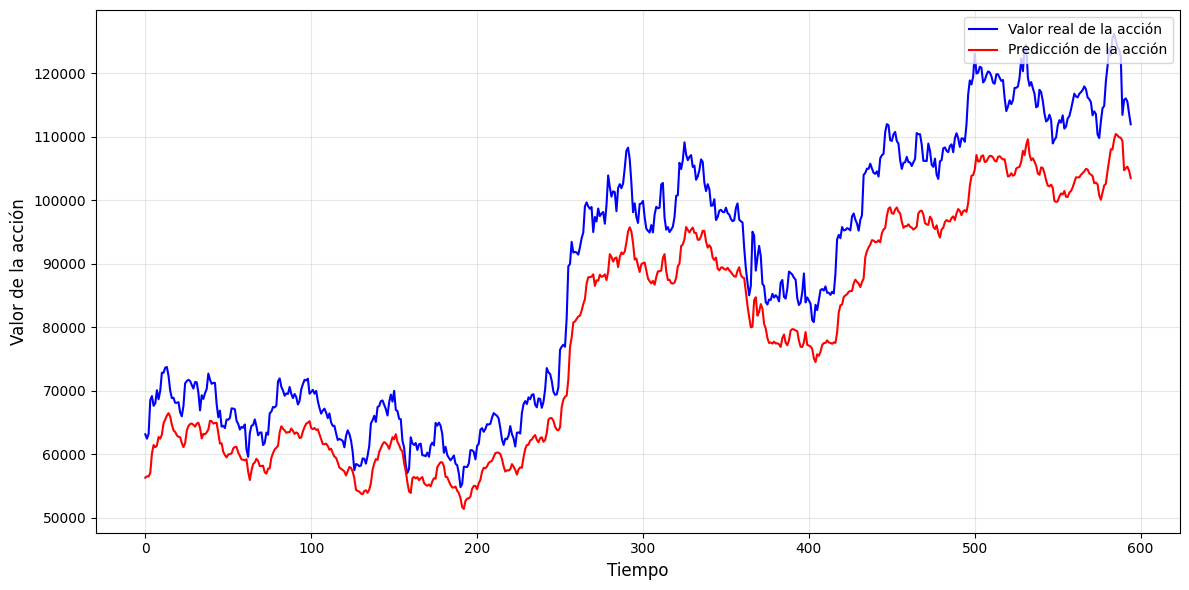

In [15]:
fechas_validacion = set_validacion.index[time_step:]
valores_reales = set_validacion.iloc[time_step:, 0].values

plt.figure(figsize=(12, 6))
plt.plot(valores_reales, label='Valor real de la acción', color='blue', linewidth=1.5)
plt.plot(prediccion, label='Predicción de la acción', color='red', linewidth=1.5)

plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Valor de la acción', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [16]:
rentability = 1
for i in range(1,len(valores_reales)):
  if prediccion[i] > valores_reales[i-1]:
    rentability*= valores_reales[i]/valores_reales[i-1]

print((rentability-1)*100,"%")

0 %


In [17]:
directional_accuracy = np.mean(
    (np.sign(prediccion[1:] - prediccion[:-1]) ==
     np.sign(valores_reales[1:] - valores_reales[:-1]))
)
print("Precisión direccional:", directional_accuracy*100, "%")

Precisión direccional: 50.02720810801618 %


In [18]:
daily_return = (rentability ** (1/len(valores_reales))) - 1
print(daily_return * 100, "% por día")

0.0 % por día


In [19]:
dias_futuros = 10

ultimo_bloque = df['High'].values[-time_step:]
ultimo_bloque_escalado = scaler.transform(ultimo_bloque.reshape(-1, 1))

predicciones_futuras = []

bloque_actual = ultimo_bloque_escalado.copy()

for i in range(dias_futuros):
    X_futuro = bloque_actual.reshape(1, time_step, 1)
    prediccion_escalada = modelo.predict(X_futuro, verbose=0)
    predicciones_futuras.append(prediccion_escalada[0, 0])
    bloque_actual = np.append(bloque_actual[1:], prediccion_escalada)

predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)
predicciones_futuras = scaler.inverse_transform(predicciones_futuras)

from datetime import timedelta
ultima_fecha = df.index[-1]
fechas_futuras = [ultima_fecha + timedelta(days=i+1) for i in range(dias_futuros)]

print("PREDICCIONES PARA LOS PRÓXIMOS", dias_futuros, "DÍAS:")
print("="*60)
for fecha, precio in zip(fechas_futuras, predicciones_futuras):
    print(f"{fecha.strftime('%Y-%m-%d')}: ${precio[0]:,.2f}")
print("="*60)

c:\Users\jeron\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


PREDICCIONES PARA LOS PRÓXIMOS 10 DÍAS:
2025-10-17: $102,325.98
2025-10-18: $97,127.06
2025-10-19: $93,209.36
2025-10-20: $90,169.38
2025-10-21: $87,383.28
2025-10-22: $84,727.69
2025-10-23: $82,168.34
2025-10-24: $79,689.11
2025-10-25: $77,279.38
2025-10-26: $74,931.24
